In [124]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from collections import Counter,Counter,defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
#import random
import warnings
warnings.filterwarnings("ignore")

In [125]:
data = pd.read_csv('Snapchat_reviews.csv')
data.head()

,Unnamed: 0,userName,rating,review,isEdited,date,title
0,0,Savvanananahhh,4,For the most part I quite enjoy Snapchat it’s ...,False,10/4/20 6:01,Performance issues
1,1,Idek 9-101112,3,"I’m sorry to say it, but something is definite...",False,10/14/20 2:13,What happened?
2,2,William Quintana,3,Snapchat update ruined my story organization! ...,False,7/31/20 19:54,STORY ORGANIZATION RUINED!
3,3,an gonna be unkown😏,5,I really love the app for how long i have been...,False,4/22/21 14:10,The app is great
4,4,gzhangziqi,1,This is super frustrating. I was in the middle...,False,10/2/20 13:58,"Locked me out, customer service not helping"


# Exploratory data analysis

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9560 entries, 0 to 9559
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9560 non-null   int64 
 1   userName    9560 non-null   object
 2   rating      9560 non-null   int64 
 3   review      9560 non-null   object
 4   isEdited    9560 non-null   bool  
 5   date        9560 non-null   object
 6   title       9560 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 457.6+ KB


In [127]:
pd.isnull(data).sum()

Unnamed: 0    0
userName      0
rating        0
review        0
isEdited      0
date          0
title         0
dtype: int64

In [128]:
# There are 9560 reviews in the dataset
len(data)

9560

In [129]:
# While most reviewers leave a 5 star review, there are also a good portion leaving 1 star reviews
data.rating.value_counts()

4    2346
3    2171
5    1932
1    1879
2    1232
Name: rating, dtype: int64

In [130]:
# Remove 3 rating reviews
data = data[data.rating!=3]
data

,Unnamed: 0,userName,rating,review,isEdited,date,title
0,0,Savvanananahhh,4,For the most part I quite enjoy Snapchat it’s ...,False,10/4/20 6:01,Performance issues
3,3,an gonna be unkown😏,5,I really love the app for how long i have been...,False,4/22/21 14:10,The app is great
4,4,gzhangziqi,1,This is super frustrating. I was in the middle...,False,10/2/20 13:58,"Locked me out, customer service not helping"
5,5,jehducfkdkdk123,1,I am very unsatisfied with the new update and ...,False,9/17/20 2:59,Opinion on new update 👎🏽🤮
6,6,Cakegirl300,4,"My Snapchat, along with many others, has sudde...",False,7/11/20 16:23,Great app and all but FIX THIS
...,...,...,...,...,...,...,...
9554,9554,EpicRicky,1,If I can give his crappy app a 0 star I would....,False,6/29/19 18:15,DONT GET THIS CRAPPY APP
9555,9555,geekygirl17,1,I used to love using Snapchat and now I hardly...,False,6/24/19 0:58,Major issue...not that it will get fixed
9556,9556,changemaker kkdd,2,"Well, I did deleted it because there was some ...",False,6/23/19 13:42,I got then deleted it.
9557,9557,teekay2much,4,Every time I upload a photo or video to my sto...,False,6/3/19 3:35,Story problem


In [131]:
# Set 4/5 rating reviews to positive, the rest to negative
data['sentiment'] = np.where(data['rating'] >= 4, 'good', 'bad')

# Include only the sentiment and reviews columns
data = data[['sentiment', 'review']]
data.head()

,sentiment,review
0,good,For the most part I quite enjoy Snapchat it’s ...
3,good,I really love the app for how long i have been...
4,bad,This is super frustrating. I was in the middle...
5,bad,I am very unsatisfied with the new update and ...
6,good,"My Snapchat, along with many others, has sudde..."


In [132]:
# Check the length of the new dataset
len(data)

7389

In [133]:
# Note that the dataset has mostly positive reviews
data.sentiment.value_counts(normalize=True)

good    0.578969
bad     0.421031
Name: sentiment, dtype: float64

In [134]:
data["review"][0]

'For the most part I quite enjoy Snapchat it’s probably the most used app I have on my phone because it’s really convenient for messaging people especially when my texting doesn’t work based on various locations, like text messages don’t go through when I’m at school buildings but Snapchat messages will. I think it’s quite useful and it’s very fun to use, however lately I’ve been experiencing some problems with loading times. For the past maybe two months it’s taking a good 10 seconds to load in a text that I got, and another three to save that text. I’ve been on various Wi-Fi connections as well as using my data and no matter the change between Wi-Fi or data the problem does not get fixed so I know that’s not the issue. Recently I found that deleting some of the things that take up storage on my phone help with the performance however this time that has not worked. I do think that this is some thing Snapchat needs to look into as a problem since it is one of the main communication app

# Preprocess the text


In [135]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def stopword(string):
    stop_words.extend(['ive', 'cant', 'im', 'dont', 'doesnt','want','u','ill','wont','friend','thing',' would','one','even','snapchat','app','s','snap','people'])
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)


lemma = WordNetLemmatizer()
def lemmatizer(string):
    a=[lemma.lemmatize(i) for i in word_tokenize(string) ]
    return " ".join(a)

stem = PorterStemmer()
def stemmer(string):
    a=[stem.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

In [136]:
data["lemma"] = data["review"].apply(lambda x: lemmatizer(stopword(preprocess(x))))

In [137]:
data.head(20)

,sentiment,review,lemma
0,good,For the most part I quite enjoy Snapchat it’s ...,part quite enjoy probably used phone really co...
3,good,I really love the app for how long i have been...,really love long using say difficulty also req...
4,bad,This is super frustrating. I was in the middle...,super frustrating middle sending logged tried ...
5,bad,I am very unsatisfied with the new update and ...,unsatisfied new update pretty sure others say ...
6,good,"My Snapchat, along with many others, has sudde...",along many others suddenly started malfunction...
7,bad,"My snapchat got hacked about a month ago, whic...",got hacked month ago know isnt entirely fault ...
8,bad,My first account that was locked was an accoun...,first account locked account since elementary ...
9,bad,I have had my snap account for a while but the...,account wanted create new lasted three day new...
10,good,So I recently just got the current update of S...,recently got current update well many know nec...
11,good,I can say confidently that me and all of my fr...,say confidently friend spend time brought many...


In [138]:
 test = data[data['lemma'] != data['review']]

In [139]:
test.lemma[0]

'part quite enjoy probably used phone really convenient messaging especially texting work based various location like text message go school building message think quite useful fun use however lately experiencing problem loading time past maybe two month taking good second load text got another three save text various wi fi connection well using data matter change wi fi data problem get fixed know thats issue recently found deleting thing take storage phone help performance however time worked think need look problem since main communication apps time get annoyed taking long load use text message instead wish didnt resort hope fix problem soon'

In [140]:
test.review[0]

'For the most part I quite enjoy Snapchat it’s probably the most used app I have on my phone because it’s really convenient for messaging people especially when my texting doesn’t work based on various locations, like text messages don’t go through when I’m at school buildings but Snapchat messages will. I think it’s quite useful and it’s very fun to use, however lately I’ve been experiencing some problems with loading times. For the past maybe two months it’s taking a good 10 seconds to load in a text that I got, and another three to save that text. I’ve been on various Wi-Fi connections as well as using my data and no matter the change between Wi-Fi or data the problem does not get fixed so I know that’s not the issue. Recently I found that deleting some of the things that take up storage on my phone help with the performance however this time that has not worked. I do think that this is some thing Snapchat needs to look into as a problem since it is one of the main communication app

<AxesSubplot:xlabel='sentiment', ylabel='count'>

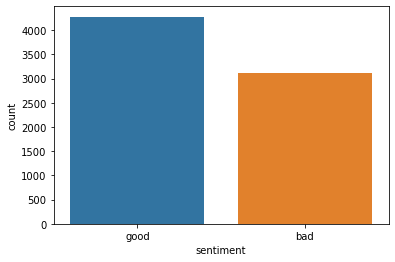

In [141]:
sns.countplot(x='sentiment',data=data)

In [142]:
positive_reviews = data.loc[(data['sentiment'] == 'good')]
positive_reviews

,sentiment,review,lemma
0,good,For the most part I quite enjoy Snapchat it’s ...,part quite enjoy probably used phone really co...
3,good,I really love the app for how long i have been...,really love long using say difficulty also req...
6,good,"My Snapchat, along with many others, has sudde...",along many others suddenly started malfunction...
10,good,So I recently just got the current update of S...,recently got current update well many know nec...
11,good,I can say confidently that me and all of my fr...,say confidently friend spend time brought many...
...,...,...,...
9551,good,I love snapchat so much. The update where the ...,love much update chat option way people story ...
9552,good,"Right now, other than a couple bugs here and t...",right couple bug good part would love got chan...
9553,good,Like this app is great and all but the stories...,like great story friend post show already seen...
9557,good,Every time I upload a photo or video to my sto...,every time upload photo video story upload lat...


In [143]:
negative_reviews = data.loc[(data['sentiment'] == 'bad')]
negative_reviews

,sentiment,review,lemma
4,bad,This is super frustrating. I was in the middle...,super frustrating middle sending logged tried ...
5,bad,I am very unsatisfied with the new update and ...,unsatisfied new update pretty sure others say ...
7,bad,"My snapchat got hacked about a month ago, whic...",got hacked month ago know isnt entirely fault ...
8,bad,My first account that was locked was an accoun...,first account locked account since elementary ...
9,bad,I have had my snap account for a while but the...,account wanted create new lasted three day new...
...,...,...,...
9539,bad,I have old pictures from before I realized you...,old picture realized could change setting ever...
9544,bad,so basically every time i open a message it ta...,basically every time open message take hour lo...
9554,bad,If I can give his crappy app a 0 star I would....,give crappy star would first thing first crash...
9555,bad,I used to love using Snapchat and now I hardly...,used love using hardly ever camera quality x a...


In [144]:
words=positive_reviews['lemma'].tolist()
words=''.join(words)

In [145]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

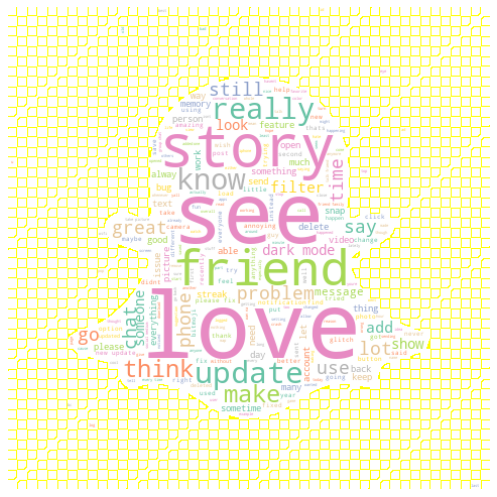

In [146]:
mask = np.array(Image.open("snap3.png"))

wc = WordCloud(background_color='white', mask=mask, mode='RGB',
               width=1000, max_words=500, height=1000,
               random_state=1, contour_width=1,contour_color='yellow',colormap='Set2')
wc.generate(words)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

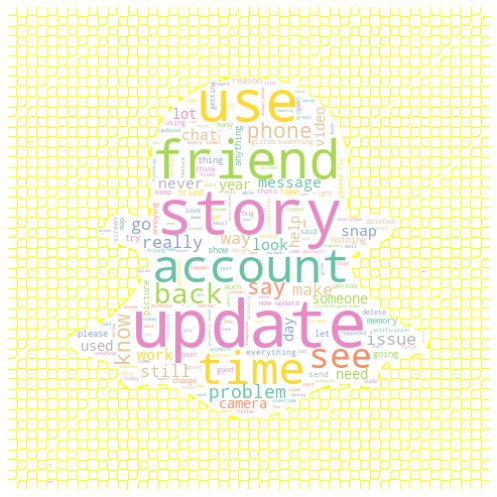

In [147]:
words2=negative_reviews['lemma'].tolist()
words2=''.join(words2)
mask = np.array(Image.open("snap3.png"))

wc = WordCloud(background_color='white', mask=mask, mode='RGB',
               width=1000, max_words=500, height=1000,
               random_state=1, contour_width=1,contour_color='yellow',colormap='Set2')
wc.generate(words2)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

In [202]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['lemma'], 20)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 unigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [195]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['lemma'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [196]:
example = positive_reviews['lemma']
example2= negative_reviews['lemma']

In [197]:
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(positive_reviews['lemma'])
doc_word.shape

(4278, 5750)

In [198]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# NMF Topicing

##### Positive Reviews

In [153]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [154]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10) 


Topic  0
like, really, update, add, good, see, make, change, also, think

Topic  1
please, back, get, fix, time, update, phone, problem, go, camera

Topic  2
friend, love, filter, use, way, great, fun, really, chat, make

Topic  3
story, see, post, video, private, view, go, watch, fix, posted

Topic  4
would, mode, dark, could, think, make, love, change, great, feature


In [155]:
NMF_df = pd.DataFrame(doc_topic.round(5),
             index = example,
             columns = ["Time _proplem","Account",'App','Snap','People'])
NMF_df

,Time _proplem,Account,App,Snap,People
lemma,,,,,
part quite enjoy probably used phone really convenient messaging especially texting work based various location like text message go school building message think quite useful fun use however lately experiencing problem loading time past maybe two month taking good second load text got another three save text various wi fi connection well using data matter change wi fi data problem get fixed know thats issue recently found deleting thing take storage phone help performance however time worked think need look problem since main communication apps time get annoyed taking long load use text message instead wish didnt resort hope fix problem soon,0.12674,0.56328,0.08834,0.00000,0.02239
really love long using say difficulty also request new update many going like idea maybe saving chat taken phone get checked friend ykand save every little chat send gc every time phone get checked since still child ofci get trouble grounded thing sendu wan na know anyways thats request also thinking give dark mode heard thinking dark mode heard long ago also thinking take call rlly know like call jus dumb way called call facetime device us call opinion like call idky also request maybe send chat give notif person said bc sometimes like opening nobody text oksnap great thing rlly please thing might said might like someone year wanted give opinion maybe idea new updat,0.57381,0.37712,0.26079,0.00000,0.10490
along many others suddenly started malfunctioning send streak itll say sent check later say streak day sent make seem though havent sent received anything though know cause said delivered said snap disappeared reappeared wouldnt let open also deleted video story day hasnt letting view certain story like try itll glitch onto another story seems happen video story tried restarting phone tried logging back account attempting wouldnt let back like would try open would immediately crash talked friend several issue well tried deleting reinstalling taking forever reinstall like longer usual idk whats going please fix soon,0.24181,0.36935,0.00000,0.47203,0.16103
recently got current update well many know necessarily like change flow bit much feature exist anymore like able access map better clicking however like swipe left instead opening conversation go map many u would rather able swipe conversation like used understand update likely lot work think would nice could get option decide swiping left open chat map may next update add feature setting pick whether swiping left open map chat sure many would appreciate although understand would take lot work either way amazing really small problem feel many would appreciate choice still putting five five star though despite update still love,0.46275,0.24433,0.03611,0.00000,0.62355
say confidently friend spend time brought many know together way never seen capable another far favorite used easy use smooth appealing layout criticize simply make suggestion enjoy watching show tab often find losing show watching noticed thumbnail change go story make hard find clicked first place particular keep finding thinking wow enjoyed show remember channel though watched minute ago thus would propose sort history feature page would like personal story show tab possibly keep hidden spot need often thing feature like would help find subscribe show enjoy thank reading,0.21444,0.04845,0.10398,0.27731,0.34421
...,...,...,...,...,...
love much update chat option way people story became bigger personal snapchats inconvenient see full picture screenshot there full bar distracting,0.01326,0.00938,0.11170,0.12619,0.01071
right couple bug good part would love got changed making put video eye longer second,0.00000,0.02970,0.04855,0.00842,0.10724
like great story friend post show already seen repeat go back old story irritates hope fix already reported hope get fixed really fast,0.09581,0.07560,0.06246,0.23623,0.00000


##### Negative Reviews

In [156]:
vectorizer2 = CountVectorizer()
doc_word2 = vectorizer2.fit_transform(negative_reviews['lemma'])
doc_word2.shape

(3111, 6469)

In [157]:
nmf_model2 = NMF(5)
doc_topic2= nmf_model2.fit_transform(doc_word2)

In [158]:
display_topics(nmf_model2, vectorizer2.get_feature_names(), 10) 


Topic  0
time, get, fix, send, problem, say, back, message, snap, phone

Topic  1
account, locked, get, back, email, new, reason, got, permanently, support

Topic  2
update, like, new, back, chat, map, make, swipe, change, look

Topic  3
story, ad, see, friend, like, post, video, page, watch, make

Topic  4
camera, phone, picture, iphone, take, quality, photo, look, use, issue


In [159]:
NMF_df2 = pd.DataFrame(doc_topic2.round(5),
             index = example2,
             columns = ["Service","LockedAccount",'UpdateApp','Timing','CameraQuality'])
NMF_df2

,Service,LockedAccount,UpdateApp,Timing,CameraQuality
lemma,,,,,
super frustrating middle sending logged tried logging said temporarily locked account hour reached support twitter multiple time sent multiple request support website an never send confirmation case ticket number request think theyre reading anything anymore many experiencing issue look support twitter reply customer service freaking terrible using last resort keep sending tweet account locked theyre helping unlock legit account sent link unlock legit account working basically account still locked get unlock tell unlock didnt break regulation thing would trigger lockdown account can not otherwise communicate number social medium way contact photo still memory downloading data isnt working either really need get account back,0.11426,0.81709,0.00000,0.00000,0.00000
unsatisfied new update pretty sure others say year worst update far format completely different way complicated use able open message sliding finger across person name slide bring u map leaving u tap message instead able slide benefit sliding able slide able peak message fully open someone bothering respond youre ghosting someone able read message without knowing update using year get use tapping instead sliding also preferred map didnt page like previously pinch finger camera access map final problem bottom icon wasnt clear purpose thing make look androidy unprofessional also suggest allowing u change usernames arent stuck stupid immature one came kid besides perfect new update didnt wanted phone automatically updated plzz go back previous version,0.12025,0.00000,0.81141,0.00000,0.10825
got hacked month ago know isnt entirely fault went every step told still havent helped keep saying email isnt associated account make sense reason knew someone trying hack got email customer service phone number everytime try reach get exact message though write help box keep getting message keep asking contact different way help repeatedly get told private photo viewed someone know nothing deactivate account unpleased company many privacy issue customer service issue need fixed prove phone number connected fact make new account confirm picture saved deleted take legal action someone could steal photo phone number email address talk without knowing give personal information hasnt handled properly could give zero star would super careful downloading privacy breached,0.19794,0.42104,0.00000,0.00530,0.33244
first account locked account since elementary many memory picture friend sudden get locked didnt tell reason contacted never able log account month made new account account literally new barely friend next know get locked unlocked using email hour later get locked account permanently deleted apparently suspicion account barely made hour account stopped using cause frustrated locking account yesterday made new account keep touch friend another state since missed using hour setting account stuff get locked locked time hour ago permanently locked contacted sent bot respond account got locked none reason nothing wasnt switching device wasnt hacking anything like wasnt adding without email verified proof email number verified reason lock account,0.00000,1.57822,0.00000,0.00750,0.00000
account wanted create new lasted three day new account first locked minute ok logged back everything fine minute didnt pas account permanently locked confused since wasnt anything wrong harmless decided make another account morning everything fine got locked didnt last two hour logged back talking sudden kick account really frustrated wasnt absolutely nothing fun talking friend went website realized account permanently locked gave point would like know happening getting angry might well delete since make account locked getting irritated would like explanation fact guy personal support email contact guy instead using website pretty difficult would much easier guy email anyways would like know account getting locked without lasting whole day nothi

# Corecx Topicing

In [160]:
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=2000,
                            token_pattern='\\b[a-z][a-z]+\\b',
                            binary=True)
doc_word = vectorizer.fit_transform(positive_reviews['lemma'])
words = list(np.asarray(vectorizer.get_feature_names()))

In [161]:
pip install corextopic

Note: you may need to restart the kernel to use updated packages.


In [162]:
from corextopic import corextopic as ct

In [163]:
topic_model = ct.Corex(n_hidden=3, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=positive_reviews)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: fix,tried,please fix,working,wifi,try,problem,say,bug,open
1: dark,dark mode,mode,friend,fun,family,communicate,social medium,filter,friend family
2: would,could,feature,like,change,add,would love,better,wish,idea


In [164]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [165]:
positive_reviews['spacy_doc'] = list(nlp.pipe(positive_reviews.lemma))

In [166]:
negative_reviews['spacy_doc'] = list(nlp.pipe(negative_reviews.lemma))

In [167]:
positive_reviews

,sentiment,review,lemma,spacy_doc
0,good,For the most part I quite enjoy Snapchat it’s ...,part quite enjoy probably used phone really co...,"(part, quite, enjoy, probably, used, phone, re..."
3,good,I really love the app for how long i have been...,really love long using say difficulty also req...,"(really, love, long, using, say, difficulty, a..."
6,good,"My Snapchat, along with many others, has sudde...",along many others suddenly started malfunction...,"(along, many, others, suddenly, started, malfu..."
10,good,So I recently just got the current update of S...,recently got current update well many know nec...,"(recently, got, current, update, well, many, k..."
11,good,I can say confidently that me and all of my fr...,say confidently friend spend time brought many...,"(say, confidently, friend, spend, time, brough..."
...,...,...,...,...
9551,good,I love snapchat so much. The update where the ...,love much update chat option way people story ...,"(love, much, update, chat, option, way, people..."
9552,good,"Right now, other than a couple bugs here and t...",right couple bug good part would love got chan...,"(right, couple, bug, good, part, would, love, ..."
9553,good,Like this app is great and all but the stories...,like great story friend post show already seen...,"(like, great, story, friend, post, show, alrea..."
9557,good,Every time I upload a photo or video to my sto...,every time upload photo video story upload lat...,"(every, time, upload, photo, video, story, upl..."


In [168]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [169]:
Counter(pos_adj).most_common(10)

[('new', 914),
 ('great', 882),
 ('good', 576),
 ('able', 569),
 ('many', 519),
 ('dark', 497),
 ('open', 461),
 ('annoying', 365),
 ('amazing', 316),
 ('black', 285)]

In [170]:
Counter(neg_adj).most_common(10)

[('new', 1190),
 ('many', 650),
 ('open', 539),
 ('able', 416),
 ('annoying', 334),
 ('black', 324),
 ('good', 321),
 ('old', 320),
 ('last', 248),
 ('delete', 240)]

In [171]:
print('Positive Adjective: ',Counter(pos_adj).most_common(5))
print('Negative Adjective: ',Counter(neg_adj).most_common(5))
print('Positive Noun: ',Counter(pos_noun).most_common(5))
print('Negative Noun: ',Counter(neg_noun).most_common(5))

Positive Adjective:  [('new', 914), ('great', 882), ('good', 576), ('able', 569), ('many', 519)]
Negative Adjective:  [('new', 1190), ('many', 650), ('open', 539), ('able', 416), ('annoying', 334)]
Positive Noun:  [('friend', 1873), ('love', 1578), ('story', 1426), ('time', 1293), ('update', 1015)]
Negative Noun:  [('account', 2167), ('time', 1560), ('story', 1369), ('update', 1332), ('friend', 1197)]


# Prepare data for modeling


In [172]:
# Split the data into X and y data sets
X = data.review
y = data.sentiment

In [173]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [174]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,00,000,006,00am,00pm,062,07,10,100,1000,...,zstevens38,ᗒᗩᗕ,ꫀꪝꪝꪝꫛ,𐂅𓅪,𓃦ˁ,𝒄𝒐𝒏𝒄𝒆𝒓𝒏𝒆𝒅,𝒖𝒔𝒆𝒓,𝒗𝒆𝒓𝒚,𝘤𝘢𝘺𝘭𝘢𝘢𝘢𝘢,𝘭𝘰𝘷𝘦
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,00,00 does,00 morning,00 night,00 pm,000,000 ads,000 day,000 days,000 doesn,...,𓃦ˁ,𓃦ˁ ꫀꪝꪝꪝꫛ,𝒄𝒐𝒏𝒄𝒆𝒓𝒏𝒆𝒅,𝒄𝒐𝒏𝒄𝒆𝒓𝒏𝒆𝒅 𝒖𝒔𝒆𝒓,𝒖𝒔𝒆𝒓,𝒗𝒆𝒓𝒚,𝒗𝒆𝒓𝒚 𝒄𝒐𝒏𝒄𝒆𝒓𝒏𝒆𝒅,𝘤𝘢𝘺𝘭𝘢𝘢𝘢𝘢,𝘭𝘰𝘷𝘦,𝘭𝘰𝘷𝘦 𝘤𝘢𝘺𝘭𝘢𝘢𝘢𝘢
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Try classifying using Logistic Regression

In [176]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [177]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [178]:

   # Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [179]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

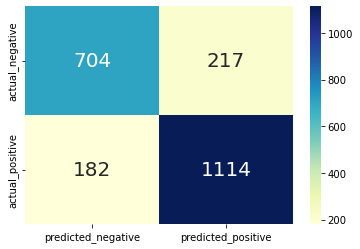

In [180]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

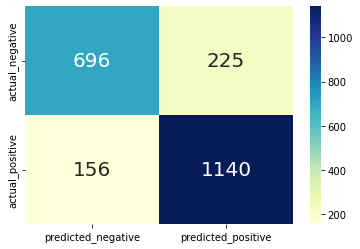

In [181]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [182]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.820,0.828
Precision,0.837,0.835
Recall,0.860,0.880
F1 Score,0.848,0.857


### The first Naive Bayes model outperforms both Logistic Regression models.



# Try classifying using Naive Bayes


In [183]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [184]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

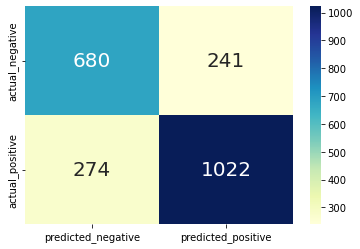

In [185]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

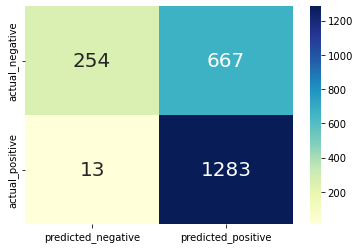

In [186]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [187]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.820,0.828,0.768,0.693
Precision,0.837,0.835,0.809,0.658
Recall,0.860,0.880,0.789,0.990
F1 Score,0.848,0.857,0.799,0.791


# Try using TF-IDF instead of Count Vectorizer

In [188]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

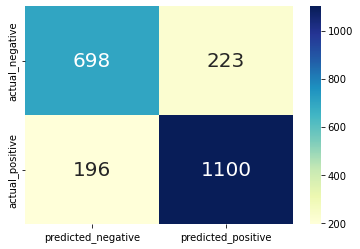

In [189]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

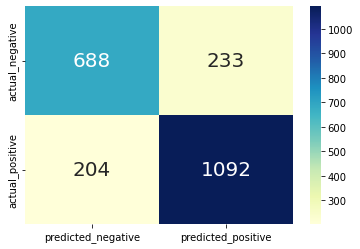

In [190]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

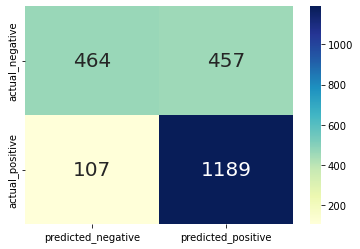

In [191]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

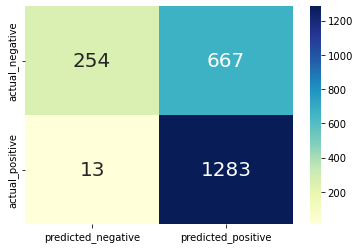

In [192]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [193]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

,LogReg1,LogReg2,NB1,NB2,LR1-TFIDF,LR2-TFIDF,NB1-TFIDF,NB2-TFIDF
Accuracy,0.820,0.828,0.768,0.693,0.811,0.803,0.746,0.693
Precision,0.837,0.835,0.809,0.658,0.831,0.824,0.722,0.658
Recall,0.860,0.880,0.789,0.990,0.849,0.843,0.917,0.990
F1 Score,0.848,0.857,0.799,0.791,0.840,0.833,0.808,0.791



### Overall, the second Logistic Regression model (using n_bigram and counts) seems to best classify positive and negative reviews.